#### Part 1: verification against Gala

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# add src to sys.path
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# packages
from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
from gala.units import galactic
import astropy.units as u

# constants
KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)
print("conversion: " + str(KM_S_TO_KPC_MYR))

conversion: 0.001022712165045695


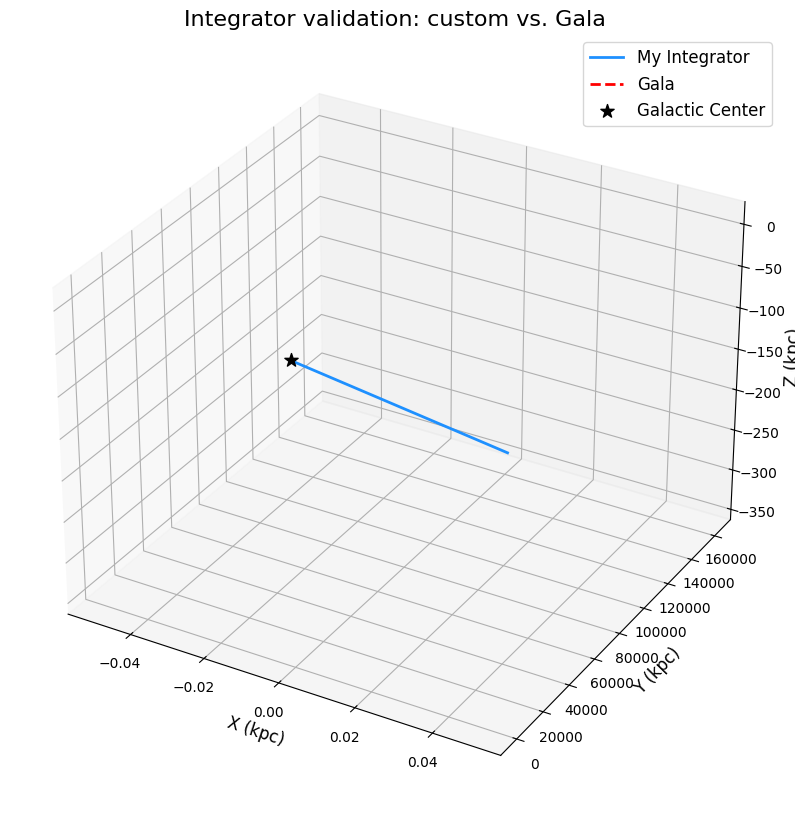

In [6]:
custom_potential = MWPotential()
gala_potential = gp.MilkyWayPotential2022()

initial_pos = np.array([0., 100, 0])
initial_vel = np.array([0, -1, -2])

initial_vel_kpcmyr = initial_vel * KM_S_TO_KPC_MYR

# custom integration parameters
N_STEPS = 5000
DT = -0.5 # Myr
times = np.arange(0, N_STEPS * DT, DT)

# run custom integrator
my_orbit = np.zeros((N_STEPS, 6))
my_orbit[0] = np.concatenate([initial_pos, initial_vel_kpcmyr])

for i in range(1, N_STEPS):
    prev_pos = my_orbit[i-1, :3]
    prev_vel = my_orbit[i-1, 3:]
    new_pos, new_vel = leapfrog_step(prev_pos, prev_vel, DT, custom_potential.get_acceleration)
    my_orbit[i] = np.concatenate([new_pos, new_vel])


# run gala integrator
initial = gd.PhaseSpacePosition(pos=initial_pos * u.kpc,
                                vel=initial_vel * u.km / u.s)
gala_orbit = gala_potential.integrate_orbit(initial, dt=DT * u.Myr,
                                            n_steps=N_STEPS-1,
                                            Integrator=gi.LeapfrogIntegrator)

# plot results
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(my_orbit[:, 0], my_orbit[:, 1], my_orbit[:, 2],
        label='My Integrator', lw=2, color='dodgerblue')

ax.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
        label='Gala', lw=2, color='red', linestyle='--')

ax.scatter(0, 0, 0, color='black', s=100, marker='*', label='Galactic Center')

ax.set_xlabel("X (kpc)", fontsize=12)
ax.set_ylabel("Y (kpc)", fontsize=12)
ax.set_zlabel("Z (kpc)", fontsize=12)
ax.set_title("Integrator validation: custom vs. Gala", fontsize=16)
ax.legend(fontsize=12)
plt.show()